In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import xradio
import numba
import os
import sys
sys.path.append(os.getcwd()+"/src")

import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
import toolviper
from calviper.factory.jones import CalibrationMatrix
import calviper as cv

# Janky imports for now
#import sys
#sys.path.append(os.getcwd()+"/src")

from src.calviper.base import JonesMatrix
from src.calviper.jones import GainJones
from src.calviper.visEquation import VisEquation
from src.calviper.table import CalibrationTable

from toolviper.utils.data import download
from toolviper.utils.data import list_files
from toolviper.dask import local_client
import xradio.measurement_set as ms

from xradio.measurement_set.convert_msv2_to_processing_set import convert_msv2_to_processing_set
from xradio.measurement_set import open_processing_set

# Import casatools and tasks to check the gaincal ref tables?
# from casatools import table
# tb = table()

In [3]:
if not pathlib.Path.cwd().joinpath("data/gaincaltest2.ps.zarr").exists():
    download("gaincal.test.zarr", "data")

In [4]:
viper_client = local_client(cores=4, memory_limit="4GB")

[2025-02-12 10:27:07,269]     INFO    viperlog:  Module path: /Users/nschweig/miniconda3/envs/xradio/lib/python3.12/site-packages/toolviper 
[2025-02-12 10:27:07,277]  WARNING    viperlog:  It is recommended that the local cache directory be set using the dask_local_dir parameter. 
[2025-02-12 10:27:10,063]     INFO    viperlog:  Client <MenrvaClient: 'tcp://127.0.0.1:50155' processes=4 threads=4, memory=14.90 GiB> 


In [5]:
processing_set = "data/gaincaltest2.ps.zarr"

# Full processing set
gaincal_ms = ms.open_processing_set(processing_set)
pd.set_option('display.max_rows', None)

# Get subset with calibration intents sel scan 2
selected_calibraters = gaincal_ms.sel(intents="CALIBRATE_DELAY#ON_SOURCE", scan_number=2)
# We select the first one to test on
# For now we select one time, channel and pol?
#print(selected_calibraters)
cal_test = selected_calibraters['gaincaltest2_0']
#print(selected_calibraters.summary())
# These are the model visibilities?
#print(cal_test.VISIBILITY)
mean_vis = cal_test.VISIBILITY.mean(dim=["time", "frequency"])
#test_vis = cal_test.VISIBILITY[0,:,0,:]
test_vis = cal_test.VISIBILITY
#print(test_vis)


#test_vis = mean_vis[:,0,:]
#print('time' in test_vis.coords)
test_vis = mean_vis
test_vis

<xarray.DataArray 'VISIBILITY' (baseline_id: 45, polarization: 4)> Size: 1kB
dask.array<mean_agg-aggregate, shape=(45, 4), dtype=complex64, chunksize=(45, 4), chunktype=numpy.ndarray>
Coordinates:
    baseline_antenna1_name  (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
    baseline_antenna2_name  (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
  * baseline_id             (baseline_id) int64 360B 0 1 2 3 4 ... 41 42 43 44
  * polarization            (polarization) <U2 32B 'XX' 'XY' 'YX' 'YY'

In [6]:
# Generate a Jones matrix with these visibilites
# This is a 2x2 matrix for each baseline currently
test_jones = GainJones.from_visibility(test_vis)
test_jones.matrix

<xarray.DataArray 'VISIBILITY' (baseline_id: 45, polarization: 4)> Size: 1kB
array([[ 9.01718616e-01-8.42339471e-02j,  7.92180712e-04-1.95596623e-03j,
         3.11153563e-04+1.40059029e-03j,  1.05672550e+00+1.80104285e-01j],
       [ 8.99499834e-01-1.09584309e-01j,  8.94097844e-04+2.65524327e-03j,
        -1.89840363e-03+1.90207676e-03j,  9.65938747e-01+4.12986577e-01j],
       [ 8.25610101e-01-3.25503051e-01j, -9.79775563e-04-2.21860199e-03j,
        -7.01053417e-04-9.44786763e-04j,  9.28861320e-01+4.06606495e-01j],
       [ 8.30625415e-01-1.79605991e-01j, -6.79876539e-04+8.11425678e-04j,
         4.09226952e-04+4.32553235e-04j,  6.34482265e-01+7.03883708e-01j],
       [ 6.90422714e-01-4.17330563e-01j,  2.22807750e-04-1.33489678e-03j,
        -1.72487588e-03-1.33420178e-03j,  6.38534248e-01+6.09641552e-01j],
       [ 6.95165217e-01-3.63277644e-01j,  1.14132876e-04-5.05108765e-05j,
         3.42600653e-03+6.36895711e-04j,  3.93130869e-01+7.44997263e-01j],
       [ 6.52869284e-01-4.20787245e-01j, -1.38476002e-03-2.01340509e-03j,
         5.82548440e-04-1.45360956e-03j,  2.53234386e-01+7.78665960e-01j],
       [ 5.31587064e-01-5.59313476e-01j,  1.12103269e-04-7.75379711e-04j,
         1.12199620e-03-1.57919037e-03j,  2.24717557e-01+7.66024828e-01j],
       [ 6.30557239e-01-4.38986987e-01j, -4.54234367e-04+5.99370804e-04j,
        -1.69540953e-03-4.06603474e-04j, -1.37737066e-01+7.61755645e-01j],
       [ 8.95232439e-01-2.78744828e-02j,  6.70772046e-04+9.66682623e-04j,
         1.08848768e-03+1.01035205e-03j,  9.91471529e-01+2.35081241e-01j],
...
        -2.39898698e-04+4.72579006e-04j,  6.48323774e-01-1.19742900e-02j],
       [ 9.74397659e-01-7.16116875e-02j, -7.29184423e-04-2.49658083e-03j,
        -4.51489876e-04-3.61314276e-04j,  8.37835908e-01+4.06266004e-01j],
       [ 5.94142914e-01-3.40717018e-01j,  5.98091447e-06+4.50812367e-04j,
         3.32898647e-03+8.62163361e-05j,  6.16268635e-01+1.66695431e-01j],
       [ 8.87157857e-01-6.86614364e-02j, -1.14000728e-03-5.48683282e-04j,
        -5.12223123e-05-6.36349898e-04j,  4.60244328e-01+6.70681119e-01j],
       [ 6.87772810e-01+1.41232371e-01j, -5.21956710e-04+5.45209390e-04j,
         1.03856740e-03-2.10313266e-03j,  5.85757613e-01+2.91770071e-01j],
       [ 9.40808892e-01-3.28797370e-01j, -8.42342270e-04-2.37234199e-04j,
         1.07083144e-03+1.35685329e-03j,  8.95474494e-01+1.68777391e-01j],
       [ 6.65662706e-01+5.45691550e-02j, -4.56431124e-04-1.12208026e-03j,
        -1.26672874e-03+3.53673269e-04j,  3.85142952e-01+4.56001967e-01j],
       [ 6.18801832e-01-2.98975170e-01j, -2.14590094e-04-2.26744651e-05j,
         4.72721906e-04+8.81050888e-04j,  6.06179833e-01-1.12495877e-01j],
       [ 1.00187290e+00+3.32352109e-02j, -8.28625562e-05+8.78351973e-04j,
        -6.76597585e-04-1.71194389e-03j,  7.47212648e-01+4.64236766e-01j],
       [ 5.76853156e-01+1.88466921e-01j, -1.28450873e-03+1.81012758e-04j,
        -1.37826684e-03-1.44295138e-03j,  4.35388833e-01+2.87443846e-01j]],
      dtype=complex64)
Coordinates:
    baseline_antenna1_name  (baseline_id) <U9 2kB 'DA41_A110' ... 'DA49_A127'
    baseline_antenna2_name  (baseline_id) <U9 2kB 'DA42_A123' ... 'DA50_A108'
  * baseline_id             (baseline_id) int64 360B 0 1 2 3 4 ... 41 42 43 44
  * polarization            (polarization) <U2 32B 'XX' 'XY' 'YX' 'YY'

<xarray.DataArray 'baseline_id' ()> Size: 8B
array(0)
Coordinates:
    baseline_antenna1_name  <U9 36B 'DA41_A110'
    baseline_antenna2_name  <U9 36B 'DA42_A123'
    baseline_id             int64 8B 0
    frequency               float64 8B 8.607e+10
    polarization            <U2 8B 'XX'


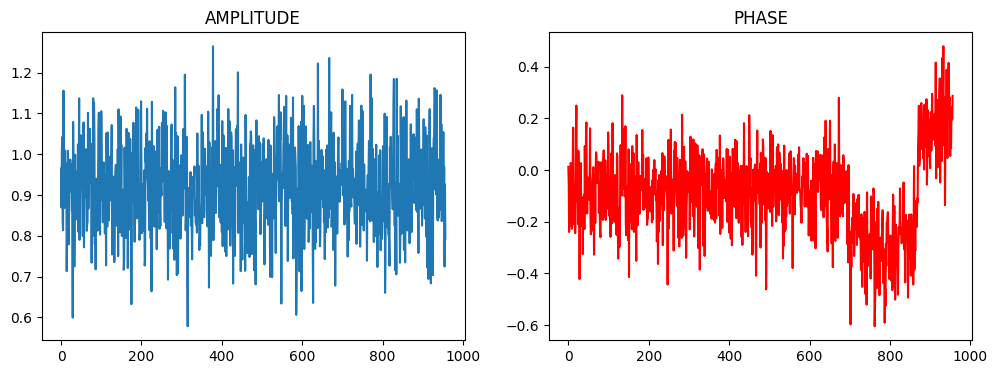

In [7]:
# Plot the XX pol model vis for one baseline for channel 0
to_plot = cal_test.VISIBILITY[:,0,0,0]
print(to_plot.baseline_id.compute())
plot_jones = GainJones.from_visibility(to_plot)

fig, axs = plt.subplots(1,2, figsize=(12, 4))
axs[0].set_title('AMPLITUDE')
axs[0].plot(np.abs(plot_jones.matrix))
axs[1].set_title('PHASE')
axs[1].plot(np.angle(plot_jones.matrix), color='r')
plt.show()


In [8]:
# Setting up the vis equation
VE = VisEquation()
VE.setSolve(test_jones)

print(test_jones.matrix.data.shape)
#test_jones.matrix.baseline_antenna1_name.to_numpy()

#dir(test_jones)
#print(test_jones.get_type)
# Set solve won't do much do much if we don't have any apply stages
# The set_solve re-orders the pre-apply steps to fit the current type into the correct location in the order

# Make VE using the set_solve assuming reordering in the future and make solve that calls Josh's solver? 
# Attempt scipy optimize for now?

Arranging VisEquation to solve for G GainJonesMatrix
(45, 4)


In [9]:
# ==== JUST FOR TESTING SOLVER WITH scipy.optimize =====

def solveFunc(params, vis_obs, vis_model):
    ant1 = params[:4].reshape(2,2)
    ant2 = params[4:].reshape(2,2)
    vis_model = np.asarray(vis_model).reshape(2,2)
    vis_obs = vis_obs.reshape(2,2)
    #print(ant1, vis_model)
    res = np.dot(ant1, vis_model)
    res = np.dot(vis_model, np.conj(ant2))
    #print(((vis_obs - res).flatten()))
    return ((vis_obs - res).flatten())

# solve func should be gradient (should I just use chi2 for now...)

# for now we assume point-like source for model vis
# 1s with same shape as solve vis (make diagonal 0?)

# === UNUSED FOR NOW ===
model_vis = np.ones(np.shape(test_jones.matrix), dtype=complex)
# Make diag 0's
for i in range(len(model_vis)):
    model_vis[i][1] = 0+0j
    model_vis[i][2] = 0+0j
# ======================

# flatten vectors for the params to solve for
def to_vector(m1, m2):
    vec = np.hstack([m1.flatten(), m2.flatten()])
    return abs(vec)

# testing with vis dict? key value retrieval of obs_vis
def build_vis_dict(obs_vis):
    """
    returns the matrix that gives the observered vis value for each baseline
    ant1 x ant2 with each ant val being a 2x2 of the polarizations
    """
    ants = set(obs_vis.matrix.baseline_antenna1_name.values)
    ants = ants.union(set(obs_vis.matrix.baseline_antenna2_name.values))
    n_ant = len(ants)
    vis_dict = {}

    # for each baseline and the reverse assign the observed visibility
    for item in obs_vis.matrix:
        #print(item)
        _vis = item.values
        _ant1 = str(item.baseline_antenna1_name.values)
        _ant2 = str(item.baseline_antenna2_name.values)
        #print(_ant1, _ant2, _vis)
        
        if (_ant1, _ant2) not in vis_dict.keys():
            vis_dict[(_ant1, _ant2)] = _vis

        if (_ant2, _ant1) not in vis_dict.keys():
            vis_dict[(_ant2, _ant1)] = _vis

    return vis_dict
    
#print(build_vis_dict(test_jones))
    
# solver with scipy.optimize.least_squares
def solve(solve_vis, model_vis=(1+0j), starting_guess=[1+0j,0+0j,0+0j,1+0j]):
    # Currently just returning a dict of antenna gains
    # This can be changed to return an Xarray object
    solved_vals = {}
    vis_dict = build_vis_dict(solve_vis)
    tracking = {}

    ant_set = set(solve_vis.matrix.baseline_antenna1_name.values)
    ant_set = ant_set.union(set(solve_vis.matrix.baseline_antenna2_name.values))
    
    # For all ants in baselines init solution to starting guess
    for i in solve_vis.matrix:
        solved_vals.setdefault(str(i.baseline_antenna1_name.values), np.asarray(starting_guess))
        solved_vals.setdefault(str(i.baseline_antenna2_name.values), np.asarray(starting_guess))

        # Tracking for plots
        tracking.setdefault(str(i.baseline_antenna1_name.values), [np.asarray(starting_guess)])
        tracking.setdefault(str(i.baseline_antenna2_name.values), [np.asarray(starting_guess)])

    
    # all baseline pairs solved a dict instead of vis matrix
    # probably worse since we are doing a lot of looping but it lets us solve for all pols at once?
    for i in ant_set:
        for j in ant_set:
            if i == j: continue;

            ant1_gain = solved_vals[i]
            ant2_gain = solved_vals[j]
            ants = to_vector(ant1_gain, ant2_gain)

            res = least_squares(solveFunc, ants, args=(vis_dict[(i, j)], starting_guess))
            solved_vals[i] = res.x[:4]
            solved_vals[j] = res.x[4:]

            tracking[i].append(res.x[:4])
            tracking[j].append(res.x[4:])

            #print(res)
        

    print('---- after 1 iterations ----')
    for k,v in solved_vals.items():
        print(k, v)

    # ===== PLOTTING FOR FUN =====
    for k, v in tracking.items():
        #print(np.asarray(v)[:, :])
        p = [i[0] for i in v]
        plt.plot(p)
        break
        
    plt.show()
    # ==============================
    return solved_vals

#solved_vals = solve(test_jones, model_vis)

In [10]:
def generate_xr(solved_vals):
    xds = xr.Dataset(coords=solved_vals)
    #xds.assign_coords(solved_vals)

    return xds

#generate_xr(solved_vals)

6.672172426364071e-06


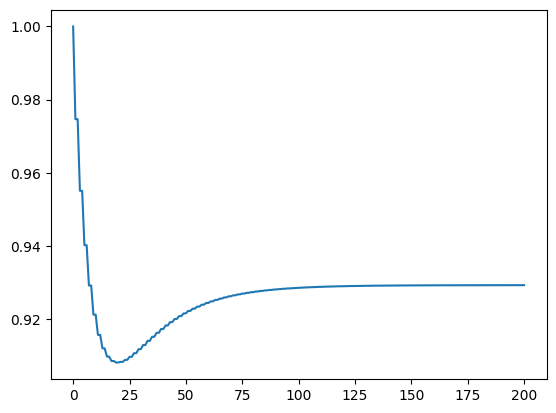

In [66]:
solved, tracked = VE.solve(plot=True)

In [67]:
solved
for k,v in solved.coords.items():
    print(k, abs(v.data))

DA41_A110 [0.92924615 1.02637395]
DA42_A123 [0.93113077 1.00911387]
DA43_A115 [0.93341928 0.98903026]
DA44_A120 [0.91114134 0.94854847]
DA45_A091 [0.89014461 0.90514125]
DA46_A129 [0.88590951 0.87676   ]
DA47_A074 [0.87099812 0.84695275]
DA48_A070 [0.88814353 0.84192829]
DA49_A127 [0.85318002 0.80084445]
DA50_A108 [0.85632948 0.78249436]


1.0449999570846558
1.0349999997124766
1.0250000161234472
1.0150000124416336
1.005000039452442
0.9950000311508318
0.9850000122551557
0.9749999728598117
0.9650000134282626
0.9549999833106995
--------------------------------------------------


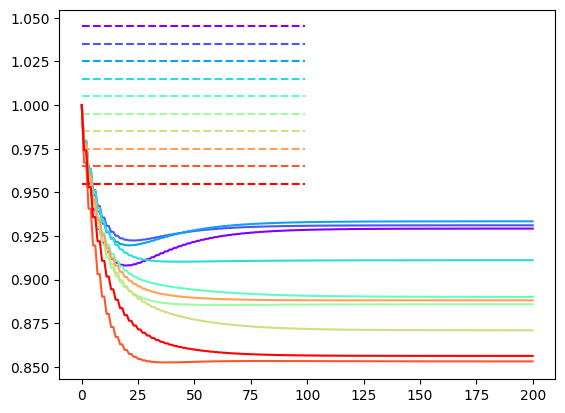

In [70]:
cal_data_path = "data/stored_cals.txt"
ref_cal = np.loadtxt(cal_data_path, dtype=complex)
# should be (2, 1, 40)
# 
#print(ref_cal.shape)
from matplotlib.pyplot import cm
color = cm.rainbow(np.linspace(0, 1, 10))

# for spw 0 print ant vals
# gains for one pol for 10 ant in spw 0
count = 0
for i in ref_cal[1,:10]:
    print(abs(i))
    plt.plot([abs(i)] * 100, linestyle='--', color=color[count])
    count += 1
    #break
print('-' * 50)
count = 0
for k, v in tracked.items():
    #print(k, v)
    p = [abs(i) for i in np.asarray(v)[:,0]]
    plt.plot(p, color=color[count])
    count += 1
    #break
    
plt.show()

In [14]:
#test_vis.frequency.compute().values
cal_test
#[p for value in mxds.polarization.values for p in list(value)]

<xarray.MeasurementSetXds> Size: 20MB
Dimensions:                     (baseline_id: 45, time: 957, frequency: 8,
                                 polarization: 4, uvw_label: 3)
Coordinates:
    baseline_antenna1_name      (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
    baseline_antenna2_name      (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
  * baseline_id                 (baseline_id) int64 360B 0 1 2 3 ... 41 42 43 44
    scan_number                 (time) int64 8kB dask.array<chunksize=(957,), meta=np.ndarray>
  * time                        (time) float64 8kB 1.503e+09 ... 1.503e+09
  * frequency                   (frequency) float64 64B 8.607e+10 ... 8.629e+10
  * polarization                (polarization) <U2 32B 'XX' 'XY' 'YX' 'YY'
  * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 345kB dask.array<chunksize=(957, 45), meta=np.ndarray>
    FLAG                        (time, baseline_id, frequency, polarization) bool 1MB dask.array<chunksize=(957, 45, 8, 4), meta=np.ndarray>
    TIME_CENTROID               (time, baseline_id) float64 345kB dask.array<chunksize=(957, 45), meta=np.ndarray>
    UVW                         (time, baseline_id, uvw_label) float64 1MB dask.array<chunksize=(957, 45, 3), meta=np.ndarray>
    VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 11MB dask.array<chunksize=(957, 45, 8, 4), meta=np.ndarray>
    WEIGHT                      (time, baseline_id, frequency, polarization) float32 6MB dask.array<chunksize=(957, 45, 8, 4), meta=np.ndarray>
Attributes:
    creation_date:     2024-12-17T00:23:00.044895+00:00
    data_groups:       {'base': {'correlated_data': 'VISIBILITY', 'flag': 'FL...
    observation_info:  {'observer': ['lknee'], 'project': 'uid://A002/X1f841f...
    partition_info:    {'field_name': ['J2255-3500_0'], 'intents': ['CALIBRAT...
    processor_info:    {'sub_type': 'ALMA_CORRELATOR_MODE', 'type': 'CORRELAT...
    schema_version:    4.0.-9994
    type:              visibility
    xradio_version:    0.0.45
    antenna_xds:       <xarray.Dataset> Size: 2kB\nDimensions:               ...

In [15]:
ctable = CalibrationTable()
res = ctable.create_table(factory='gain').empty_like(dataset=cal_test)
#res["GAIN"][0,:,0,:]
pars = ['TIME',
 'FIELD_ID',
 'SPECTRAL_WINDOW_ID',
 'ANTENNA1',
 'ANTENNA2',
 'INTERVAL',
 'SCAN_NUMBER',
 'OBSERVATION_ID',
 'CPARAM',
 'PARAMERR',
 'FLAG',
 'SNR',
 'WEIGHT']
res
# using other data?
#ctable.create_table(factory='gain').empty_like(dataset=mxds)

[2025-02-12 10:27:14,345]     INFO    viperlog:  Module path: /Users/nschweig/RADPScal/calviper/src/calviper 


<xarray.Dataset> Size: 1MB
Dimensions:       (time: 957, antenna: 10, frequency: 8, polarization: 2,
                   gain: 1, scan_id: 957)
Coordinates:
  * time          (time) float64 8kB 1.503e+09 1.503e+09 ... 1.503e+09 1.503e+09
  * antenna       (antenna) <U9 360B 'DA41_A110' 'DA42_A123' ... 'DA50_A108'
  * frequency     (frequency) float64 64B 8.607e+10 8.61e+10 ... 8.629e+10
  * polarization  (polarization) <U1 8B 'X' 'Y'
  * scan_id       (scan_id) int64 8kB 2 2 2 2 2 2 2 2 ... 26 26 26 26 26 26 26
  * gain          (gain) float64 8B 1.0
Data variables:
    GAIN          (time, antenna, frequency, polarization, gain) float64 1MB ...
Attributes:
    calibration_type:  gain

In [16]:
# mean_vis
'''
V = mean_vis.data.compute()

VE = VisEquation()
VE.setSolve(test_jones)
solved = VE.solve(plot=False)

solved
'''

'\nV = mean_vis.data.compute()\n\nVE = VisEquation()\nVE.setSolve(test_jones)\nsolved = VE.solve(plot=False)\n\nsolved\n'